<a href="https://colab.research.google.com/github/shantanu6378/Bubble-wrap-ANOVA/blob/main/Group10_stat_480_ukraine_twitter_finalproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Popularity Prediction on Ukraine Conflict Tweets 

### Install ngrok

In [ ]:
%%bash

## Setup port-forwarding

# Download ngrok
wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# Unload ngrok
unzip -qo ngrok-stable-linux-amd64.zip

In [ ]:
# Set ngrok authtoken once per-session
!./ngrok authtoken 286rzhgBkhBeIztD7IryWlIPzPL_78TuD6FWoQyDqpA2NdBkZ

# Start an HTTP tunnel forwarding to your local port 4050
get_ipython().system_raw('./ngrok http 4050 &')

# Open a local host port
!curl -s http://localhost:4040/api/tunnels

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
{"tunnels":[],"uri":"/api/tunnels"}


# Environment Setup

### Mount Google Drive

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Data_480

/content/drive/.shortcut-targets-by-id/19avAQ6MusyUGaQiJDqGXLxBKnCbTBOhb/Data_480


### Install PySpark

In [ ]:
%%bash 
pip install pyspark
pip install -U -q PyDrive
apt install openjdk-8-jdk-headless -qq

  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=9da845bcae2d8f75b4a5f23785c3be1b67a0ce0ed9aeda2b73062f60adb444a0
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unsel

### Enable packages

In [ ]:
pip install scikit-plot

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%tensorflow_version 2.x
import tensorflow as tf
from pyspark.sql.functions import isnan, when, count, col, countDistinct
import sklearn
print(sklearn.__version__)
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score ,confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import scikitplot as skplt

import re
#import emoji
import nltk
import warnings 
warnings.filterwarnings("ignore")
print(f"python: {sys.version}")
print(f"pandas: {np.__version__}")
print(f"tensorflow: {tf.__version__}")
# Detect if a GPU is present
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  print(f"GPU Enabled: True")
else:
  print(f"GPU Enabled: False")

try:
  from google.colab import drive
  is_google_colab = True

  print("Notebook is on Google CoLab")
except:
  is_google_colab = False
  print("Notebook is being run locally or through another source.")


1.0.2
python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
pandas: 1.21.6
tensorflow: 2.8.0
GPU Enabled: False
Notebook is on Google CoLab


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz

tar: spark-3.0.1-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


### Initialize Spark cluster

In [ ]:
import pyspark 
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# Set configuration scope to be local and use port 4050
config_scope = SparkConf().set("spark.ui.port", "36250")
#config_scope = SparkConf().set("spark.executor.memory", "4g")

# Create the connection to a Spark cluster
sc = pyspark.SparkContext(conf = config_scope)

# Create a session to programmatically build Spark RDD, DataFrame and DataSet
spark = SparkSession.builder.getOrCreate()

In [ ]:
'''
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
'''

# Load Data

### Unzip data

## Rename file

In [ ]:
%%bash
#/content/UkraineCombinedTweetsDeduped20220227-131611.csv.gzip
#/content/UkraineCombinedTweetsDeduped20220227-131611.csv.gz
#/content/0401_UkraineCombinedTweetsDeduped.csv.gzip
cp /content/drive/MyDrive/Data_480/0401_UkraineCombinedTweetsDeduped.csv.gzip /content/drive/MyDrive/Data_480/0401_UkraineCombinedTweetsDeduped.csv.gz
#other files are directly renamed

## Extract with gunzip

In [ ]:
%%bash

#not needed

gunzip -k /content/drive/MyDrive/Data_480/0401_UkraineCombinedTweetsDeduped.csv.gz

gzip: /content/drive/MyDrive/Data_480/0401_UkraineCombinedTweetsDeduped.csv already exists;	not overwritten


## Read with Spark

In [ ]:
df = spark.read.csv(
  "/content/drive/MyDrive/Data_480", 
  sep=',', header='true', inferSchema = 'true')
 

In [ ]:
df.show(5)

+--------------------+------------------+------------+--------------------+--------+--------------------+-------------------+--------------------+-------------+--------------------+--------------------+------------+----+--------+--------------------+-----------+--------------+-----------+
|                 _c0|            userid|    username|            acctdesc|location|           following|          followers|         totaltweets|usercreatedts|             tweetid|      tweetcreatedts|retweetcount|text|hashtags|            language|coordinates|favorite_count|extractedts|
+--------------------+------------------+------------+--------------------+--------+--------------------+-------------------+--------------------+-------------+--------------------+--------------------+------------+----+--------+--------------------+-----------+--------------+-----------+
|                   0|699759327913967617|RuidoEnLaRed|Periodismo audiov...|    null|                null|               null|     

In [ ]:
#df.describe().show()

In [ ]:
# Writing the data to a csv file for use on local computer:
#df_en.write.csv("/content/drive/MyDrive/Data_480/tweets_en.csv", header = 'true')

In [ ]:
#df_en.show()

# Exploratory Data Analysis

### Basic Information

In [ ]:
print(df.count(), len(df.columns)) #no of rows, cols

39047346 18


In [ ]:
df.columns

['_c0',
 'userid',
 'username',
 'acctdesc',
 'location',
 'following',
 'followers',
 'totaltweets',
 'usercreatedts',
 'tweetid',
 'tweetcreatedts',
 'retweetcount',
 'text',
 'hashtags',
 'language',
 'coordinates',
 'favorite_count',
 'extractedts']

### Data Cleaning & Preprocessing

In [ ]:
#drop 1st col

df = df.drop("_c0")

#selecting only English tweets and only 100000 rows

df_en = df.filter(df.language == "en").limit(100000)
df_en.count()

100000

In [ ]:
df_en.select([count(when(isnan(c)| col(c).isNull(), c)).alias(c) for c in df_en.columns]).show(5)

+------+--------+--------+--------+---------+---------+-----------+-------------+-------+--------------+------------+----+--------+--------+-----------+--------------+-----------+
|userid|username|acctdesc|location|following|followers|totaltweets|usercreatedts|tweetid|tweetcreatedts|retweetcount|text|hashtags|language|coordinates|favorite_count|extractedts|
+------+--------+--------+--------+---------+---------+-----------+-------------+-------+--------------+------------+----+--------+--------+-----------+--------------+-----------+
|     8|       2|   26257|   42121|        0|        0|          0|            0|      0|             0|           0|   0|       0|       0|      99984|             0|          0|
+------+--------+--------+--------+---------+---------+-----------+-------------+-------+--------------+------------+----+--------+--------+-----------+--------------+-----------+



In [ ]:
# For use in Databricks:
#df_en.write.parquet("en_tweets.parquet")

In [ ]:
df_en.agg(*(countDistinct(col(c)).alias(c) for c in df_en.columns)).show()

+------+--------+--------+--------+---------+---------+-----------+-------------+-------+--------------+------------+-----+--------+--------+-----------+--------------+-----------+
|userid|username|acctdesc|location|following|followers|totaltweets|usercreatedts|tweetid|tweetcreatedts|retweetcount| text|hashtags|language|coordinates|favorite_count|extractedts|
+------+--------+--------+--------+---------+---------+-----------+-------------+-------+--------------+------------+-----+--------+--------+-----------+--------------+-----------+
| 58358|   58373|   42865|   16380|     8164|     9995|      49389|        58353|  99989|         51036|        4237|23770|   18769|       1|         15|           112|     100000|
+------+--------+--------+--------+---------+---------+-----------+-------------+-------+--------------+------------+-----+--------+--------+-----------+--------------+-----------+



In [ ]:
df_en.show(10)

+-------------------+---------------+--------------------+--------------------+---------+---------+-----------+--------------------+-------------------+--------------------+------------+--------------------+--------------------+--------+-----------+--------------+--------------------+
|             userid|       username|            acctdesc|            location|following|followers|totaltweets|       usercreatedts|            tweetid|      tweetcreatedts|retweetcount|                text|            hashtags|language|coordinates|favorite_count|         extractedts|
+-------------------+---------------+--------------------+--------------------+---------+---------+-----------+--------------------+-------------------+--------------------+------------+--------------------+--------------------+--------+-----------+--------------+--------------------+
|          152930351|     AnonGhostt|   Secret for Public|                  UK|        7|     5032|     376514|2010-06-07 07:02:...|1507870013

In [ ]:
freq_table = df_en.select(col("location").cast("string")).groupBy("location").count().toPandas()

In [ ]:
freq_table["count"].sort_values(ascending = False)

16261    42121
41        1175
7          564
167        551
27         509
         ...  
7741         1
7742         1
7743         1
7745         1
16380        1
Name: count, Length: 16381, dtype: int64

In [ ]:
#Filter on relevant columns
df_en_subset = df_en.select("userid", "username", 'location', 'following', 'followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts', 'retweetcount', 'text', 'hashtags', 'language', 'favorite_count')
#df_en_subset[878]

In [ ]:
#graph of frequency of df_en_subset location variable
#sns.barplot(x = df_en.location.value_counts()[:15].index, y = df_en.language.value_counts()[:15])

In [ ]:
#df_subset = df.where((col('tweetcreatedts') > "2022-03-01 00:00:00" ) & (col('tweetcreatedts') < "2022-03-01 00:05:00" ))
#df_subset.show()
#df_en.cache()

In [ ]:
#convert pyspark dataframe to pandas
pd_df_en = df_en_subset.toPandas()
pd_df_en.head(5)

,userid,username,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,language,favorite_count
0,152930351,AnonGhostt,UK,7,5032,376514,2010-06-07 07:02:46.000000,2022-03-27 00:00:00.000000,6409,The #Anonymous collective has sent 7.000.000 anti-war texts to Russian cell phone users to tell them the truth about Putin's invasion of #Ukraine.,"[{'text': 'Anonymous', 'indices': [21, 31]}]",en,0
1,369869874,ORFMumbai,"Nariman Point, Mumbai, India",50,3239,60298,2011-09-08 02:34:54.000000,2022-03-27 00:00:00.000000,0,"In addition to adjusting to geopolitical settings, the consequences of the #RussiaUkraine war finally consolidate the “Pivot to Asia” strategy in #Russia and Belarus’ foreign policy, states Yuri M. Yarmolinsky. https://t.co/jBRr0BA6f5","[{'text': 'RussiaUkraine', 'indices': [75, 89]}, {'text': 'Russia', 'indices': [146, 153]}]",en,0
2,1459659466962571271,PbpSouthCentral,None,158,76,17,2021-11-13 23:10:08.000000,2022-03-27 00:00:01.000000,0,@PbpSouthCentral attending the protest today to end the Yemen &amp; Ukrainian Wars from the Spire in O’Connell Street to the Saudi Embassy! ✊Powerful speeches from @bridsmithTD &amp; @RBoydBarrett condemning all wars &amp; defending Irish Neutrality! @pb4p @IrishAntiWarMvt #Yemen #Ukraine https://t.co/AO6F8WdNS0,"[{'text': 'Yemen', 'indices': [274, 280]}, {'text': 'Ukraine', 'indices': [281, 289]}]",en,0
3,1184512866885558274,RStatecraft,"Washington, DC",337,17196,17760,2019-10-16 16:54:26.000000,2022-03-27 00:00:01.000000,0,Former NATO Amb. Robert Hunter: #NATO has a credibility problem that one emergency summit this week wasn't going to fix. https://t.co/FAiqPABPRT,"[{'text': 'NATO', 'indices': [32, 37]}]",en,0
4,2384105730,alphacentauriii,"Earth, Sol System.",1298,5302,92575,2014-03-11 19:24:39.000000,2022-03-27 00:00:01.000000,327,"#Ukraine: Ukrainian forces captured an R-149 series command vehicle in Olkhovka, near #Kharkiv, when the locale was retaken. It was towed back to rear areas. https://t.co/ikg4jvfT4z","[{'text': 'Ukraine', 'indices': [15, 23]}, {'text': 'Kharkiv', 'indices': [101, 109]}]",en,0


In [ ]:
#convert to csv ----> for future runtime resets (in order to not run complete dataset in pyspark)
pd_df_en.to_csv("twitter_subset_final.csv")

In [ ]:
cd /content/drive/MyDrive/Data_480

/content/drive/MyDrive/Data_480


In [ ]:
#Load csv files

pd_df_en = pd.read_csv("twitter_subset.csv", on_bad_lines='skip')


In [ ]:
'''
df = [en_df0, en_df1, en_df2, en_df3, en_df4, en_df5, en_df6, en_df7, en_df8, en_df9, en_df10,
                    en_df11, en_df12, en_df13, en_df14, en_df15, en_df16, en_df17, en_df18, en_df19, en_df20, 
                    en_df21, en_df22, en_df23, en_df24, en_df25, en_df26, en_df27, en_df28, en_df29, 
                    en_df31, en_df32, en_df33]

en_df = pd.concat(df, axis = 0, ignore_index = True)
en_df
'''

'\ndf = [en_df0, en_df1, en_df2, en_df3, en_df4, en_df5, en_df6, en_df7, en_df8, en_df9, en_df10,\n                    en_df11, en_df12, en_df13, en_df14, en_df15, en_df16, en_df17, en_df18, en_df19, en_df20, \n                    en_df21, en_df22, en_df23, en_df24, en_df25, en_df26, en_df27, en_df28, en_df29, \n                    en_df31, en_df32, en_df33]\n\nen_df = pd.concat(df, axis = 0, ignore_index = True)\nen_df\n'

In [ ]:
pd_df_en.head(2)

,Unnamed: 0,userid,username,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags,language,favorite_count
0,0,152930351,AnonGhostt,UK,7,5032,376514,2010-06-07 07:02:46.000000,2022-03-27 00:00:00.000000,6409,The #Anonymous collective has sent 7.000.000 a...,"[{'text': 'Anonymous', 'indices': [21, 31]}]",en,0
1,1,369869874,ORFMumbai,"Nariman Point, Mumbai, India",50,3239,60298,2011-09-08 02:34:54.000000,2022-03-27 00:00:00.000000,0,In addition to adjusting to geopolitical setti...,"[{'text': 'RussiaUkraine', 'indices': [75, 89]...",en,0


In [ ]:
pd_df_en["location"].nunique()

16380

In [ ]:
pd_df_en.columns

Index(['userid', 'username', 'location', 'following', 'followers',
       'totaltweets', 'usercreatedts', 'tweetcreatedts', 'retweetcount',
       'text', 'hashtags', 'language', 'favorite_count'],
      dtype='object')

In [ ]:
#Subset data on relevant columns
en_df_subset = pd_df_en[['username', 'following', 'followers', 'totaltweets', "language", 'tweetcreatedts', 'retweetcount', 'text']]
en_df_subset

,username,following,followers,totaltweets,language,tweetcreatedts,retweetcount,text
0,AnonGhostt,7,5032,376514,en,2022-03-27 00:00:00.000000,6409,The #Anonymous collective has sent 7.000.000 anti-war texts to Russian cell phone users to tell them the truth about Putin's invasion of #Ukraine.
1,ORFMumbai,50,3239,60298,en,2022-03-27 00:00:00.000000,0,"In addition to adjusting to geopolitical settings, the consequences of the #RussiaUkraine war finally consolidate the “Pivot to Asia” strategy in #Russia and Belarus’ foreign policy, states Yuri M. Yarmolinsky. https://t.co/jBRr0BA6f5"
2,PbpSouthCentral,158,76,17,en,2022-03-27 00:00:01.000000,0,@PbpSouthCentral attending the protest today to end the Yemen &amp; Ukrainian Wars from the Spire in O’Connell Street to the Saudi Embassy! ✊Powerful speeches from @bridsmithTD &amp; @RBoydBarrett condemning all wars &amp; defending Irish Neutrality! @pb4p @IrishAntiWarMvt #Yemen #Ukraine https://t.co/AO6F8WdNS0
3,RStatecraft,337,17196,17760,en,2022-03-27 00:00:01.000000,0,Former NATO Amb. Robert Hunter: #NATO has a credibility problem that one emergency summit this week wasn't going to fix. https://t.co/FAiqPABPRT
4,alphacentauriii,1298,5302,92575,en,2022-03-27 00:00:01.000000,327,"#Ukraine: Ukrainian forces captured an R-149 series command vehicle in Olkhovka, near #Kharkiv, when the locale was retaken. It was towed back to rear areas. https://t.co/ikg4jvfT4z"
...,...,...,...,...,...,...,...,...
99995,KaraTStarbuck,4827,4828,142391,en,2022-03-27 21:59:22.000000,0,Beautiful! ⁦🥰 #Ukraine culture plus #Edmonton landmarks! 🇺🇦🇨🇦@ShumkaDancers⁩ #slavaukraini https://t.co/0UqtjHmmf5
99996,PiotrZychowicz,477,65721,21313,en,2022-03-27 21:59:22.000000,255,"⚡️Commander-in-Chief of the Armed Forces of #Ukraine Valery Zaluzhny reports that in order to discredit the #Ukrainian defense forces, the enemy is shooting staged videos and asks to trust only official sources. https://t.co/DwqDtDTks0"
99997,moneymktgminute,292,226,3891,en,2022-03-27 21:59:23.000000,0,The real question is when #russia throws the false flag to invade #poland. Days? Weeks?
99998,shpida_kukurida,529,77,1323,en,2022-03-27 21:59:24.000000,8979,"Downtown Kyiv, Saturday afternoon #Ukraine https://t.co/UlupfCJShG"


In [ ]:
#Count of missing values
en_df_subset.isnull().sum()

username          2
following         0
followers         0
totaltweets       0
language          0
tweetcreatedts    0
retweetcount      0
text              0
dtype: int64

In [ ]:
#Removing missing values 
en_df_subset = en_df_subset.dropna()
en_df_subset

,username,following,followers,totaltweets,language,tweetcreatedts,retweetcount,text
0,AnonGhostt,7,5032,376514,en,2022-03-27 00:00:00.000000,6409,The #Anonymous collective has sent 7.000.000 anti-war texts to Russian cell phone users to tell them the truth about Putin's invasion of #Ukraine.
1,ORFMumbai,50,3239,60298,en,2022-03-27 00:00:00.000000,0,"In addition to adjusting to geopolitical settings, the consequences of the #RussiaUkraine war finally consolidate the “Pivot to Asia” strategy in #Russia and Belarus’ foreign policy, states Yuri M. Yarmolinsky. https://t.co/jBRr0BA6f5"
2,PbpSouthCentral,158,76,17,en,2022-03-27 00:00:01.000000,0,@PbpSouthCentral attending the protest today to end the Yemen &amp; Ukrainian Wars from the Spire in O’Connell Street to the Saudi Embassy! ✊Powerful speeches from @bridsmithTD &amp; @RBoydBarrett condemning all wars &amp; defending Irish Neutrality! @pb4p @IrishAntiWarMvt #Yemen #Ukraine https://t.co/AO6F8WdNS0
3,RStatecraft,337,17196,17760,en,2022-03-27 00:00:01.000000,0,Former NATO Amb. Robert Hunter: #NATO has a credibility problem that one emergency summit this week wasn't going to fix. https://t.co/FAiqPABPRT
4,alphacentauriii,1298,5302,92575,en,2022-03-27 00:00:01.000000,327,"#Ukraine: Ukrainian forces captured an R-149 series command vehicle in Olkhovka, near #Kharkiv, when the locale was retaken. It was towed back to rear areas. https://t.co/ikg4jvfT4z"
...,...,...,...,...,...,...,...,...
99995,KaraTStarbuck,4827,4828,142391,en,2022-03-27 21:59:22.000000,0,Beautiful! ⁦🥰 #Ukraine culture plus #Edmonton landmarks! 🇺🇦🇨🇦@ShumkaDancers⁩ #slavaukraini https://t.co/0UqtjHmmf5
99996,PiotrZychowicz,477,65721,21313,en,2022-03-27 21:59:22.000000,255,"⚡️Commander-in-Chief of the Armed Forces of #Ukraine Valery Zaluzhny reports that in order to discredit the #Ukrainian defense forces, the enemy is shooting staged videos and asks to trust only official sources. https://t.co/DwqDtDTks0"
99997,moneymktgminute,292,226,3891,en,2022-03-27 21:59:23.000000,0,The real question is when #russia throws the false flag to invade #poland. Days? Weeks?
99998,shpida_kukurida,529,77,1323,en,2022-03-27 21:59:24.000000,8979,"Downtown Kyiv, Saturday afternoon #Ukraine https://t.co/UlupfCJShG"


In [ ]:
#Clean following variable and convert to numeric
print(en_df_subset.following.unique().tolist())

['7', '50', '158', '337', '1298', '214', '1094', '937', '1869', '3959', '5227', '296', '846', '3', '8836', '591', '1784', '1741', '2509', '2114', '2021', '260', '261', '303', '640', '607', '4997', '142', '416', '92', '126', '2499', '4999', '22', '590', '748', '116', '1385', '1178', '599', '255', '3502', '2695', '472', '37271', '572', '246', '993', '9', '650', '0', '104', '13669', '1076', '913', '97', '1275', '1375', '4737', '8677', '168', '814', '5000', '207', '856', '1', '169', '211', '3774', '500', '2666', '4969', '1221', '192', '369', '235', '2631', '547', '605', '130', '361', '2374', '113', '4957', '506', '600', '100', '12803', '1793', '4884', '2086', '859', '172', '33', '910', '4308', '164', '5176', '2107', '230', '511', '2515', '12852', '2286', '1003', '731', '193', '4625', '1010', '314', '3017', '43', '1961', '397', '3946', '1268', '418', '737', '1244', '225', '1276', '405', '396', '3773', '1027', '2820', '423', '1388', '1586', '348', '161193', '5001', '221', '1788', '9018', '17

In [ ]:
en_df_subset['following'] = pd.to_numeric(en_df_subset.following, errors = 'coerce').dropna()
en_df_subset['followers'] = pd.to_numeric(en_df_subset.followers, errors = 'coerce').dropna()
en_df_subset['totaltweets'] = pd.to_numeric(en_df_subset.totaltweets, errors = 'coerce').dropna()
en_df_subset['retweetcount'] = pd.to_numeric(en_df_subset.retweetcount, errors = 'coerce').dropna()
en_df_subset["tweetcreatedts"]= pd.to_datetime(en_df_subset["tweetcreatedts"], errors = "coerce")

In [ ]:
#Clean variables and convert to numeric
print(en_df_subset.followers.unique().tolist())
print(en_df_subset.totaltweets.unique().tolist())
print(en_df_subset.retweetcount.unique().tolist())

[5032.0, 3239.0, 76.0, 17196.0, 5302.0, 189.0, 605.0, 221.0, 464.0, 664.0, 5357.0, 442.0, 38.0, 0.0, 14933.0, 308.0, 2348.0, 1294.0, 1935.0, 345.0, 185.0, 207.0, 135.0, 47.0, 269.0, 4170.0, 2590.0, 696.0, 91.0, 2046.0, 2053.0, 6.0, 36304.0, 25.0, 9.0, 226.0, 1819.0, 165.0, 97.0, 63.0, 1284.0, 975.0, 325.0, 70355.0, 350.0, 137.0, 987.0, 155.0, 51.0, 2034.0, 13336.0, 48.0, 125.0, 214.0, 988.0, 564.0, 1907.0, 9333.0, 17.0, 205.0, 1421.0, 134.0, 763.0, 132.0, 46.0, 1815.0, 264.0, 2962.0, 1138.0, 95.0, 147.0, 2054.0, 398.0, 40.0, 116.0, 32.0, 2063.0, 43.0, 3891.0, 519.0, 534.0, 14.0, 12534.0, 57.0, 4001.0, 2039.0, 907.0, 52.0, 462.0, 1625.0, 140.0, 4968.0, 1100.0, 12.0, 105.0, 1158.0, 35584.0, 1325.0, 720.0, 373.0, 78.0, 4878.0, 93.0, 299.0, 1090.0, 4.0, 1726.0, 66.0, 1908.0, 171.0, 414.0, 413.0, 721.0, 34.0, 589.0, 347.0, 24.0, 3825.0, 397.0, 431.0, 74.0, 438.0, 615.0, 39.0, 181565.0, 632.0, 103.0, 174.0, 8206.0, 984.0, 50.0, 41124.0, 285.0, 42.0, 343.0, 240.0, 51009.0, 364.0, 1448.0, 31.0

In [ ]:
#Check column ty
df_fin = pd.read_csv('twitter_subset_final.csv')
df_fin.shape

(100000, 14)

In [ ]:
en_df_subset = en_df_subset.to_csv("twitter_sub_final.csv")

In [ ]:
en_df_subset.isnull().sum()

username           0
following         27
followers          8
totaltweets       46
language           0
tweetcreatedts    53
retweetcount      54
text               0
dtype: int64

In [ ]:
en_df_subset = en_df_subset.dropna()
en_df_subset.isnull().sum()

username          0
following         0
followers         0
totaltweets       0
language          0
tweetcreatedts    0
retweetcount      0
text              0
dtype: int64

In [ ]:
pd.set_option('display.max_colwidth', None)
en_df_subset["text"][:10]

0                                                                                                                                                                           The #Anonymous collective has sent 7.000.000 anti-war texts to Russian cell phone users to tell them the truth about Putin's invasion of #Ukraine.
1                                                                                   In addition to adjusting to geopolitical settings, the consequences of the #RussiaUkraine war finally consolidate the “Pivot to Asia” strategy in #Russia and Belarus’ foreign policy, states Yuri M. Yarmolinsky. https://t.co/jBRr0BA6f5
2    @PbpSouthCentral attending the protest today to end the Yemen &amp; Ukrainian Wars from the Spire in O’Connell Street to the Saudi Embassy! ✊Powerful speeches from @bridsmithTD &amp; @RBoydBarrett condemning all wars &amp; defending Irish Neutrality! @pb4p @IrishAntiWarMvt #Yemen #Ukraine https://t.co/AO6F8WdNS0
3                                          

In [ ]:
#Sort tweets on retweet count
sort_retweets = en_df_subset.sort_values(by = 'retweetcount', ascending = False)
sort_retweets

,username,following,followers,totaltweets,language,tweetcreatedts,retweetcount,text
56956,inopinus,79.0,136.0,10446.0,en,2022-03-27 14:43:40,53436.0,The Anonymous collective is officially in cyber war against the Russian government. #Anonymous #Ukraine
60269,Afflicted999,1318.0,88.0,856.0,en,2022-03-27 15:24:46,53433.0,The Anonymous collective is officially in cyber war against the Russian government. #Anonymous #Ukraine
95538,ModalStealth,1012.0,799.0,37570.0,en,2022-03-27 21:19:49,46405.0,#Anonymous message to Vladimir Putin https://t.co/eIy9YpDvM5
94801,SkartveitNancy,28117.0,27615.0,81532.0,en,2022-03-27 21:13:53,46403.0,#Anonymous message to Vladimir Putin https://t.co/eIy9YpDvM5
89623,HansPZwetsloot,3916.0,2798.0,62111.0,en,2022-03-27 20:24:12,46401.0,#Anonymous message to Vladimir Putin https://t.co/eIy9YpDvM5
...,...,...,...,...,...,...,...,...
40600,BD317,183.0,58.0,2022.0,en,2022-03-27 11:13:10,0.0,"@POTUS @JoeBiden @HunterBiden #POTUS #Biden #JoeBiden #Corruption While we are getting little bits of info on the laptop, the truth is coming for you! #Criminal"
82281,MonkJeffKaz789,219.0,68.0,17496.0,en,2022-03-27 19:24:02,0.0,I'm so glad @JoeBiden is the President right now! If putin started war in Ukraine while Donald Trump was still president right now oh boy.. and only playing golf and doing rallies? there will be NO #Ukraine in the Google map or COUNTRY! There won't be no Ukrainian's at all..
40673,ChrisTheyers,203.0,82.0,3193.0,en,2022-03-27 11:13:37,0.0,@MedvedevRussiaE Poland doesn’t want to be complicit in your illegal invasion of #Ukraine. Or #RussianWarCrimes. Your days are numbered.
40676,Spring_dara,53.0,7.0,11901.0,en,2022-03-27 11:13:39,0.0,Pro-democracy #Myanmar 🇲🇲 nationalities and human rights activists in Republic of #Korea 🇰🇷 marched to protest against Myanmar's junta and showed solidarity with #Ukraine 🇺🇦. 🪧 #2022Mar27Coup #WhatsHappeningInMyanmar https://t.co/aN2Ex0J3aM


### Text data Pre-processing

In [ ]:
!pip install emoji

In [ ]:

sno=nltk.SnowballStemmer('english')

def cleanhtml(s): #html, code, /, < etc
    a=re.sub('[|>.*?|\.*|?.*?]',"",s)
    return a

def cleanpunc(s): #remove punctuation
    a=re.sub('[.|,|!,|)|(|/|\|”|\’|#|@|$|-|%|]',"",s)
    return a

In [ ]:
# Stopwords list:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# removing html codes, punctuation marks, stop words and doing stemming:

final = en_df_subset
i = 0
str1 = ''
final_string=[]
s = ''
for s in final['text'].values:
    f = []
    s = cleanhtml(s)
    for w in s.split():
        for c in cleanpunc(w).split():
            if ((c.isalpha()) & (len(c)>2)):
                if (c.lower() not in stop):
                    s = (sno.stem(c.lower())).encode('utf8')
                    f.append(s)
                else:
                    continue
            else:
                continue
    str1 = b" ".join(f)
    final_string.append(str1)
    i=i+1

# adding cleanedtext in final data frame

final['CleanedText'] = final_string

In [ ]:
'''
# Bag of Words:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final['CleanedText'].values)
final_counts.shape

'''

"\n# Bag of Words:\ncount_vect = CountVectorizer()\nfinal_counts = count_vect.fit_transform(final['CleanedText'].values)\nfinal_counts.shape\n\n"

In [ ]:
# categorizer:
en_df_subset = pd.read_csv('twitter_sub_final.csv')
en_df_subset['retweetcount_cat'] = np.where(en_df_subset['retweetcount']!=0, pd.cut(en_df_subset['retweetcount'], bins = [0, 100, 500, 1000, 10000, np.inf], labels=[1, 2, 3, 4, 5]), 0)


In [ ]:
en_df_subset.dtypes

Unnamed: 0            int64
username             object
following           float64
followers           float64
totaltweets         float64
language             object
tweetcreatedts       object
retweetcount        float64
text                 object
retweetcount_cat    float64
dtype: object

In [ ]:
en_df_subset = en_df_subset.to_csv("twitter_sub_final.csv")


In [ ]:
d = pd.read_csv("twitter_sub_final.csv")

In [ ]:
d.dtypes

Unnamed: 0            int64
Unnamed: 0.1          int64
username             object
following           float64
followers           float64
totaltweets         float64
language             object
tweetcreatedts       object
retweetcount        float64
text                 object
retweetcount_cat    float64
dtype: object

In [ ]:
final.isna().sum()

username            0
following           0
followers           0
totaltweets         0
language            0
tweetcreatedts      0
retweetcount        0
text                0
CleanedText         0
retweetcount_cat    0
dtype: int64

In [ ]:
final.shape

(99944, 10)

[Text(0.5, 1.0, 'Distribution of retweetcount categories')]

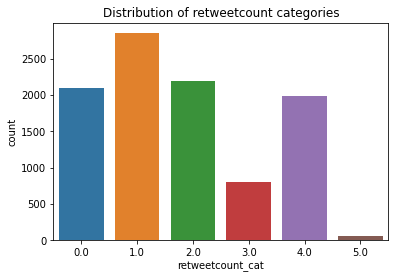

In [ ]:
sns.countplot(data = final, x = 'retweetcount_cat').set(title='Distribution of retweetcount categories')

[Text(0.5, 1.0, 'Distribution of retweetcount categories')]

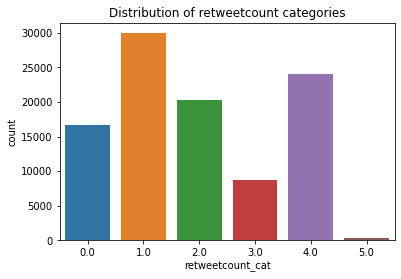

In [ ]:
sns.countplot(data = final, x = 'retweetcount_cat').set(title='Distribution of retweetcount categories')

In [ ]:
final["tweet_year"] = final["tweetcreatedts"].dt.year
final["tweet_month"] = final["tweetcreatedts"].dt.month
#final["tweet_day_of_week"] = final["tweetcreatedts"].dt.dayofweek

In [ ]:
final.columns

Index(['username', 'following', 'followers', 'totaltweets', 'language',
       'tweetcreatedts', 'retweetcount', 'text', 'CleanedText',
       'retweetcount_cat', 'tweet_year', 'tweet_month'],
      dtype='object')

In [ ]:
final.tweet_year.unique()

array([2022])

We will drop tweet_year column below as it has only 1 value throughout.

In [ ]:
df_username = final.groupby(['username'], as_index=False)['retweetcount'].sum()
df_username_tweets = final.groupby(['username'], as_index=False)['totaltweets'].sum()


In [ ]:
#sorted top 10
sorted_df_username_retweetcount = df_username.sort_values(by = "retweetcount", ascending = False).iloc[:10,:]
b= df_username_tweets.sort_values(by = "totaltweets", ascending = False).iloc[:10,:]

In [ ]:
sorted_df_username_retweetcount

,username,retweetcount
737,CatZaVi,46835.0
2205,LindaSN0228WI,46376.0
4329,bluecase,46368.0
946,DanaBax23471646,46366.0
2426,MaryGriffin28,46365.0
1179,ElbiCortezFunes,46364.0
4795,eeden_jenny,46364.0
364,AnonGhostt,32045.0
3934,Y00582094,24594.0
1956,JuneJune2206,24031.0


In [ ]:
sorted_df_username_tweetcount = df_username_tweets.sort_values(by = "totaltweets", ascending = False).iloc[:10,:]
sorted_df_username_tweetcount

,username,totaltweets
6921,tzDiscovery,12311556.0
5038,guzlomi,9710764.0
4916,freedom1970a,9005242.0
494,Bassaces1,8387564.0
2215,LiveFromDaZone,7959312.0
3314,SerendipitySays,7613964.0
2205,LindaSN0228WI,6607274.0
5166,igeusllc,6368620.0
2014,KatNL,6069222.0
5362,jornalistavitor,5428563.0


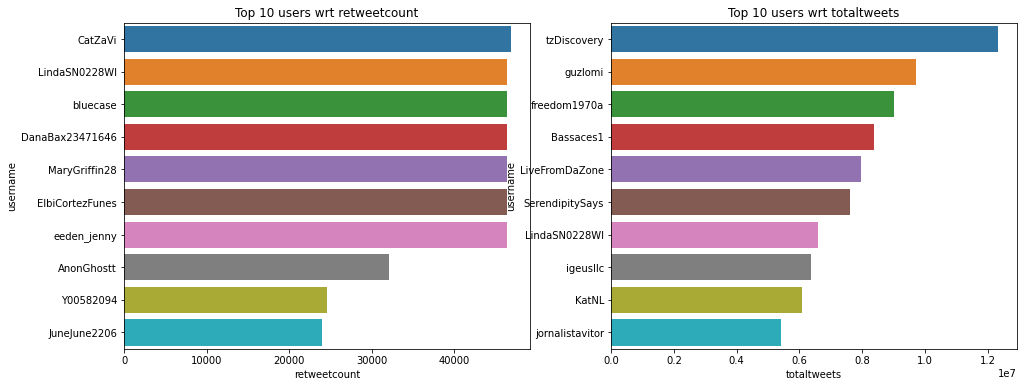

In [ ]:
#sns.barplot(data = sorted_df_username_retweetcount, x = 'retweetcount')
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.set_title('Top 10 users wrt retweetcount')
sns.barplot(x=sorted_df_username_retweetcount['retweetcount'],y=sorted_df_username_retweetcount['username'],data=sorted_df_username_retweetcount,ax=ax1)

ax2.set_title('Top 10 users wrt totaltweets')
sns.barplot(x=sorted_df_username_tweetcount['totaltweets'],y=sorted_df_username_tweetcount['username'],data=sorted_df_username_tweetcount, ax=ax2)

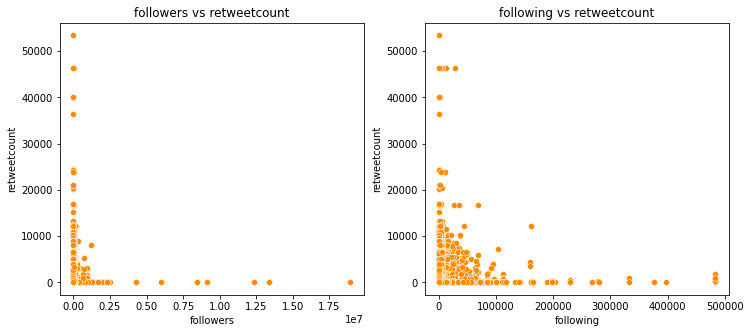

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.set_title('followers vs retweetcount')
sns.scatterplot(x='followers', y='retweetcount', data=final, color = "darkorange", ax=ax1)

ax2.set_title('following vs retweetcount')
sns.scatterplot(x='following', y='retweetcount', data=final, color = "darkorange", ax=ax2)

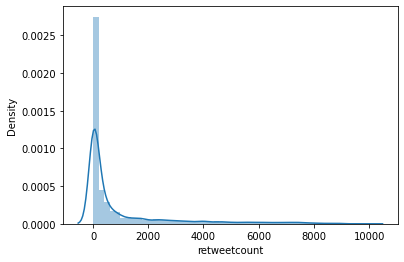

In [ ]:

sns.distplot(final[final["retweetcount"]<10000]['retweetcount'])

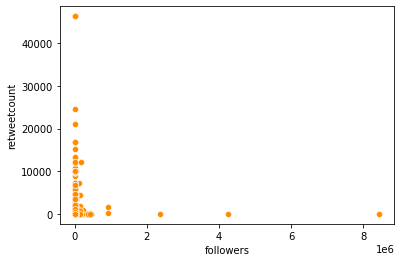

In [ ]:
sns.scatterplot(x='followers', y='retweetcount', data=final, color = "darkorange")

In [ ]:
final.head()

,username,following,followers,totaltweets,language,tweetcreatedts,retweetcount,text,CleanedText,retweetcount_cat
0,AnonGhostt,7.0,5032.0,376514.0,en,2022-03-27 00:00:00,6409.0,The #Anonymous collective has sent 7.000.000 anti-war texts to Russian cell phone users to tell them the truth about Putin's invasion of #Ukraine.,b'anonym collect sent text russian cell phone user tell truth invas ukrain',4.0
1,ORFMumbai,50.0,3239.0,60298.0,en,2022-03-27 00:00:00,0.0,"In addition to adjusting to geopolitical settings, the consequences of the #RussiaUkraine war finally consolidate the “Pivot to Asia” strategy in #Russia and Belarus’ foreign policy, states Yuri M. Yarmolinsky. https://t.co/jBRr0BA6f5",b'addit adjust geopolit set consequ russiaukrain war final consolid asia strategi russia belarus foreign polici state yuri yarmolinski',0.0
2,PbpSouthCentral,158.0,76.0,17.0,en,2022-03-27 00:00:01,0.0,@PbpSouthCentral attending the protest today to end the Yemen &amp; Ukrainian Wars from the Spire in O’Connell Street to the Saudi Embassy! ✊Powerful speeches from @bridsmithTD &amp; @RBoydBarrett condemning all wars &amp; defending Irish Neutrality! @pb4p @IrishAntiWarMvt #Yemen #Ukraine https://t.co/AO6F8WdNS0,b'pbpsouthcentr attend protest today end yemen ukrainian war spire oconnel street saudi embassi speech bridsmithtd rboydbarrett condemn war defend irish neutral irishantiwarmvt yemen ukrain',0.0
3,RStatecraft,337.0,17196.0,17760.0,en,2022-03-27 00:00:01,0.0,Former NATO Amb. Robert Hunter: #NATO has a credibility problem that one emergency summit this week wasn't going to fix. https://t.co/FAiqPABPRT,b'former nato amb robert nato credibl problem one emerg summit week go fix',0.0
4,alphacentauriii,1298.0,5302.0,92575.0,en,2022-03-27 00:00:01,327.0,"#Ukraine: Ukrainian forces captured an R-149 series command vehicle in Olkhovka, near #Kharkiv, when the locale was retaken. It was towed back to rear areas. https://t.co/ikg4jvfT4z",b'ukrainian forc captur seri command vehicl olkhovka near kharkiv local retaken tow back rear area',2.0


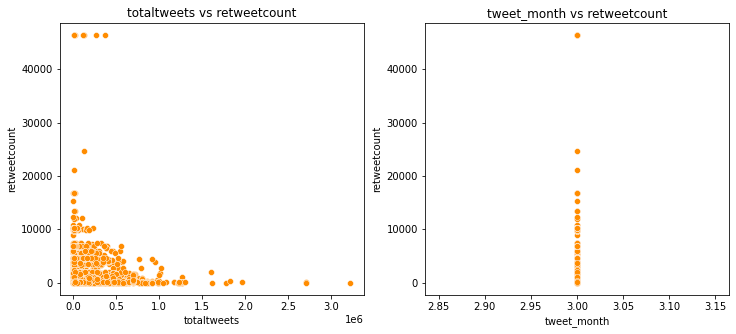

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.set_title('totaltweets vs retweetcount')
sns.scatterplot(x='totaltweets', y='retweetcount', data=final, color = "darkorange", ax=ax1)

ax2.set_title('tweet_month vs retweetcount')
sns.scatterplot(x='tweet_month', y='retweetcount', data=final, color = "darkorange", ax=ax2)

In [ ]:
import sklearn
print(sklearn.__version__)

1.0.2


In [ ]:
vectorize = sklearn.feature_extraction.text.TfidfVectorizer(analyzer = "word", max_features=30000)
tfidwords_ = vectorize.fit_transform(final.CleanedText)
final_textmat = tfidwords_.toarray()
#final_textmat.tolist()
final_textmat
#final["textmat"] = final_textmat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
bag_of_words_df = pd.DataFrame(final_textmat)
#final_textmat = final_textmat.tolist()
#final["textmat"] = pd.Series(final_textmat)
bag_of_words_df

,0,1,2,3,4,5,6,7,8,9,...,8531,8532,8533,8534,8535,8536,8537,8538,8539,8540
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
final = final.drop(columns = ['language', "tweet_year"])

In [ ]:
final_reg = final.copy()
final_reg.columns

Index(['username', 'following', 'followers', 'totaltweets', 'tweetcreatedts',
       'retweetcount', 'text', 'CleanedText', 'retweetcount_cat',
       'tweet_month'],
      dtype='object')

In [ ]:
#dataframe for the regression problem
reg_df = final_reg.drop(columns = ['username', 'tweetcreatedts', 'text', 'CleanedText', 'retweetcount_cat'])
reg_df.columns

Index(['following', 'followers', 'totaltweets', 'retweetcount', 'tweet_month'], dtype='object')

In [ ]:
#dataframe for the classification problem
cls_df = final.drop(columns = ['username', 'tweetcreatedts', 'text', 'CleanedText', 'retweetcount'])
cls_df.columns

Index(['following', 'followers', 'totaltweets', 'retweetcount_cat',
       'tweet_month'],
      dtype='object')

We have not dropped column "tweet_month" although it has single value in this dataframe because, the dataset is just a subset of the larger/original data. Increasing the index count would result in larger subset and thus may include more than 1 month.

#### Dataframe for Classification Problem

In [ ]:
print(cls_df.shape)
df_merged_cls = pd.concat([cls_df.reset_index(drop = True), bag_of_words_df], axis=1)
print(df_merged_cls.shape)

(10000, 5)
(10000, 8546)


In [ ]:
df_merged_cls.head(4)

,following,followers,totaltweets,retweetcount_cat,tweet_month,0,1,2,3,4,...,8531,8532,8533,8534,8535,8536,8537,8538,8539,8540
0,7.0,5032.0,376514.0,4.0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50.0,3239.0,60298.0,0.0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,158.0,76.0,17.0,0.0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,337.0,17196.0,17760.0,0.0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Dataframe for Regression Problem

In [ ]:
print(reg_df.shape)
df_merged_reg = pd.concat([reg_df.reset_index(drop = True), bag_of_words_df], axis=1)
print(df_merged_reg.shape)

(10000, 5)
(10000, 8546)


In [ ]:
df_merged_reg.head(4)

,following,followers,totaltweets,retweetcount,tweet_month,0,1,2,3,4,...,8531,8532,8533,8534,8535,8536,8537,8538,8539,8540
0,7.0,5032.0,376514.0,6409.0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50.0,3239.0,60298.0,0.0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,158.0,76.0,17.0,0.0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,337.0,17196.0,17760.0,0.0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

### Classification: Converting the retweet count into bins (here 6 bins, 6 class problem)

In [ ]:
#number of classes
df_merged_cls.retweetcount_cat.value_counts()

1.0    2849
2.0    2199
0.0    2096
4.0    1993
3.0     809
5.0      54
Name: retweetcount_cat, dtype: int64

In [ ]:
#Define X and Y
X = df_merged_cls.drop(columns = "retweetcount_cat")
Y = df_merged_cls[["retweetcount_cat"]]

In [ ]:
# Split the data into train and test.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)


#### LinearSVC

In [ ]:
#LinearSVC ----> over Training set
model = LinearSVC()
model.fit(X_train,Y_train)
Y_predict = model.predict(X_train)
accuracy = accuracy_score(Y_train,Y_predict)*100
print(format(accuracy, '.2f'))

29.66


In [ ]:
#LinearSVC ----> over Validation set
Y_predict = model.predict(X_val)
accuracy = accuracy_score(Y_val,Y_predict)*100
print(format(accuracy, '.2f'))

29.50


#### Logistic Regression

In [ ]:
#LogisticRegression ----> over Training set
logistic_Regression = LogisticRegression()
logistic_Regression.fit(X_train,Y_train)
Y_predict = logistic_Regression.predict(X_train)
accuracy = accuracy_score(Y_train,Y_predict)*100
print(format(accuracy, '.2f'))

28.40


In [ ]:
#LogisticRegression ----> over Validation set
Y_predict = logistic_Regression.predict(X_val)
accuracy = accuracy_score(Y_val,Y_predict)*100
print(format(accuracy, '.2f'))


28.45


In [ ]:
#fpr, tpr, thresholds = metrics.roc_curve(Y_val, Y_predict, pos_label=1)
#metrics.auc(fpr, tpr)

In [ ]:
print(f1_score(Y_val, Y_predict, average="weighted")) #to account class imbalance
print(precision_score(Y_val, Y_predict, average="weighted"))
print(recall_score(Y_val, Y_predict, average="weighted"))    

0.14785483378227451
0.14058988412850795
0.2845


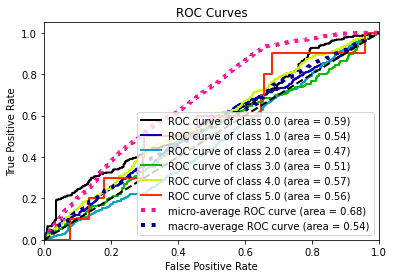

In [ ]:
Y_probas = logistic_Regression.predict_proba(X_val) # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(Y_val, Y_probas)
plt.show()

#### Naive Bayes

In [ ]:
#Naive_Bayes ----> over training set
from sklearn.naive_bayes import GaussianNB
Naive_Bayes = GaussianNB()
Naive_Bayes.fit(X_train, Y_train)
predictions = Naive_Bayes.predict(X_train)
print('The accuracy of Naive_Bayes on validation set is', accuracy_score(predictions, Y_train)*100)

The accuracy of Naive_Bayes on validation set is 22.7375


In [ ]:
#Naive_Bayes ----> over Validation set
predictions = Naive_Bayes.predict(X_val)
print('The accuracy of Naive_Bayes on validation set is', accuracy_score(predictions, Y_val)*100)

The accuracy of Naive_Bayes on validation set is 21.9


0.13038218552927977
0.2864545719452949
0.219


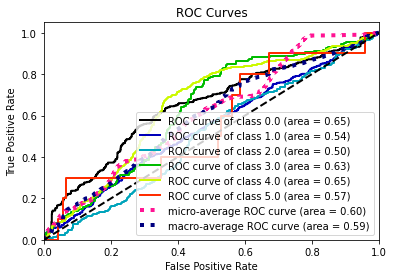

In [ ]:
print(f1_score(Y_val, predictions, average="weighted")) #to account class imbalance
print(precision_score(Y_val, predictions, average="weighted"))
print(recall_score(Y_val, predictions, average="weighted")) 
Y_probas = Naive_Bayes.predict_proba(X_val) # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(Y_val, Y_probas)
plt.show()

#### Decision Tree

In [ ]:
#DecisionTreeClassifier ----> over Training set
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
prediction_decision_tree = model.predict(X_train)
print('The accuracy of Decision Tree on training set is', accuracy_score(prediction_decision_tree, Y_train)*100)

The accuracy of Decision Tree on training set is 99.97500000000001


In [ ]:
#DecisionTreeClassifier ----> over Validation set
prediction_decision_tree = model.predict(X_val)
print('The accuracy of Decision Tree on validation set is', accuracy_score(prediction_decision_tree, Y_val)*100)

The accuracy of Decision Tree on validation set is 77.8


0.7776184015802424
0.7778208357098495
0.778


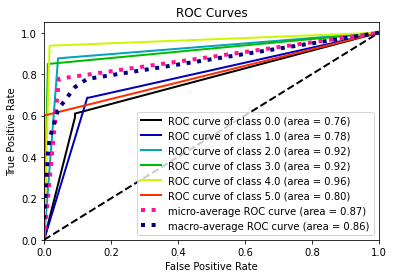

In [ ]:
print(f1_score(Y_val, prediction_decision_tree, average="weighted")) #to account class imbalance
print(precision_score(Y_val, prediction_decision_tree, average="weighted"))
print(recall_score(Y_val, prediction_decision_tree, average="weighted")) 
Y_probas = model.predict_proba(X_val) # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(Y_val, Y_probas)
plt.show()

#### Random Forest Classifier

In [ ]:
#RandomForestClassifier ----> over Training set
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
rf_predictions = clf.predict(X_train)
print('The accuracy of Random Forest on training set is', accuracy_score(rf_predictions, Y_train)*100)

The accuracy of Random Forest on training set is 99.97500000000001


In [ ]:
#RandomForestClassifier ----> over Validation set
rf_predictions = clf.predict(X_val)
print('The accuracy of Random Forest on validation set is', accuracy_score(rf_predictions, Y_val)*100)

The accuracy of Random Forest on validation set is 84.6


0.847718318397801
0.8516876036555063
0.846


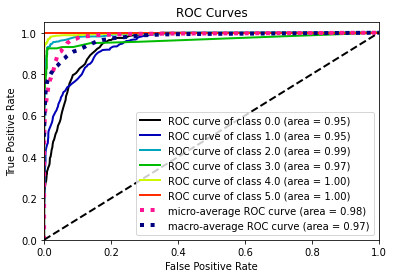

In [ ]:
print(f1_score(Y_val, rf_predictions, average="weighted")) #to account class imbalance
print(precision_score(Y_val, rf_predictions, average="weighted"))
print(recall_score(Y_val, rf_predictions, average="weighted")) 
Y_probas = clf.predict_proba(X_val) # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(Y_val, Y_probas)
plt.show()

### Regression: Considering the retweet count column as it is

In [ ]:
df_merged_reg.head(2)

,following,followers,totaltweets,retweetcount,tweet_month,0,1,2,3,4,...,8531,8532,8533,8534,8535,8536,8537,8538,8539,8540
0,7.0,5032.0,376514.0,6409.0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50.0,3239.0,60298.0,0.0,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def model_perf(model, model_name, X_test, y_test):     #helper function 
    pred_test = model.predict(X_test)
   
    median_abs_err = median_absolute_error(y_test, pred_test) #median_abs_err
    mean_abs_err = mean_absolute_error(y_test, pred_test) #mean_abs_err
    rmse = np.sqrt(mean_squared_error(y_test, pred_test)) #rmse
    r2 = r2_score(y_test, pred_test) #r2
    result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(pred_test)], axis=1)
    result.columns = ['test', 'pred']
    result['ape'] = np.abs(result['test'] - result['pred'])*100/(result['test']) #absolute percentage error
    result['err'] = result['pred'] - result['test']
    MAPE = round(np.median(result['ape']),4) #median for robust calculation -- MAPE
    model_perf = pd.DataFrame({'model_name': model_name, 'MAPE': MAPE, 'median_abs_err': median_abs_err, 'mean_abs_err':mean_abs_err,
                           'rmse': rmse, 'r2_score':r2}, index=[0])
    return model_perf, result

#### Linear Regression: To start and set a benchmark

In [ ]:
#Linear regression ---> over training data
reg = LinearRegression().fit(X_train, Y_train)
pred_lr_train = reg.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(Y_train, pred_lr_train))

0.13360796229255506

In [ ]:
#Linear regression ---> over validating data
pred_lr_val = reg.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(Y_val, pred_lr_val))
median_abs_err = median_absolute_error(Y_val, pred_lr_val) #median_abs_err
mean_abs_err = mean_absolute_error(Y_val, pred_lr_val) #mean_abs_err
r2 = r2_score(Y_val, pred_lr_val)
rmse_val,median_abs_err,mean_abs_err,r2

(1.017825968711958,
 0.0037397346856400393,
 0.4355653059114889,
 0.48655140288224297)

#### Decision Trees

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, Y_train)
pred_dt_train = clf.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(Y_train, pred_dt_train))
rmse_train

0.016359346109432526

In [ ]:
pred_dt_val = clf.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(Y_val, pred_dt_val))
median_abs_err = median_absolute_error(Y_val, pred_dt_val) #median_abs_err
mean_abs_err = mean_absolute_error(Y_val, pred_dt_val) #mean_abs_err
r2 = r2_score(Y_val, pred_dt_val)
rmse_val,median_abs_err,mean_abs_err,r2

(0.625801064545745, 0.0, 0.24582692307692305, 0.8059013511073416)

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor()
regr = regr.fit(X_train, Y_train)
pred_rf_train = clf.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(Y_train, pred_rf_train))
rmse_train

0.016359346109432526

In [ ]:
pred_rf_val = regr.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(Y_val, pred_rf_val))
median_abs_err = median_absolute_error(Y_val, pred_rf_val) #median_abs_err
mean_abs_err = mean_absolute_error(Y_val, pred_rf_val) #mean_abs_err
r2 = r2_score(Y_val, pred_rf_val)
rmse_val,median_abs_err,mean_abs_err,r2

(0.4773689350733379,
 0.040000000000000036,
 0.24049738088149894,
 0.8870572846854384)